## Tutorial 3 - Pegasi 51b Data
The third tutorial demonstrates how this code can be applied to a real set of data modelling a planetary signal as a Keplerian. It also introduces the Keplerian only plot and the phase plot as ways to display the data.

In [1]:
import numpy as np
from pathlib import Path

from magpy_rv.MCMC_aux import get_model as get_model
import magpy_rv.Parameters as par
import magpy_rv.Models as mod
import magpy_rv.Kernels as ker
import magpy_rv.GP_Likelihood as gp
from magpy_rv.MCMC import run_MCMC as run
import magpy_rv.plotting as plot
from magpy_rv.saving import save as save
import magpy_rv.auxiliary as aux

2813.2308006313287 16620.585819951895


## Importing the Data
Instead of creating fake data, this time we will work with the 1997 51 Peg Hamilton data (can be accessed via https://dace.unige.ch/radialVelocities/?pattern=51%20peg). The file was imported and the times, rvs and rv errors were read off it. Only one of the data sets was used for this tutorial, but this code is able to take multiple datasets at once which will be explained in the last tutorial.

In [2]:
# importing the file
inputfilenameDACE = '51 Peg_HAMILTON_Pub-1997'
myinput = Path('/file/path/{}.rdb'.format(inputfilenameDACE))
DACE_TOI_all = np.genfromtxt(myinput, delimiter=None, skip_header=2)
# time was converted back to the standard
time = DACE_TOI_all[:,0] + 2450000
# rv and rv errors read from the file
rv = DACE_TOI_all[:,1]
rv = rv - np.mean(rv)
rv_err = DACE_TOI_all[:,2]

Ran the data_plot function similarly to before to get an idea of what the data looks like

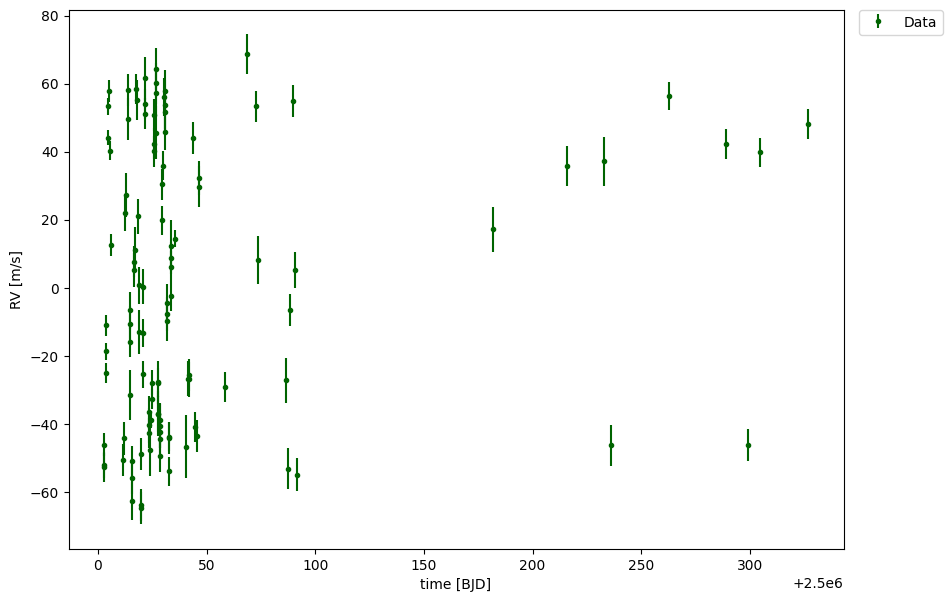

In [3]:
plot.data_plot(time, rv, y_err = rv_err)

## Creating the Kernel
Printing the kernel list the same as before shows us the list of available kernels, for this we will use a Quasi-periodic kernel with a jitter term. We can then create this kernel using the par_create function with JitterQuasiPer as the input.

The hyperparameters and priors can then be defined in the same way as the previous tutorials, only this time there are more for the different kernel. The initial guess hyperparameter values were guesses made from the data, it is likely that plotting the gp and model before the mcmc has run will not yield a very close match.

In [4]:
# check which kernels are available
ker.PrintKernelList()

Implemented kernels:
{'Cosine': ['gp_amp', 'gp_per'], 'ExpSquared': ['gp_amp', 'gp_timescale'], 'ExpSinSquared': ['gp_amp', 'gp_timescale', 'gp_per'], 'QuasiPer': ['gp_per', 'gp_perlength', 'gp_explength', 'gp_amp'], 'JitterQuasiPer': ['gp_per', 'gp_perlength', 'gp_explength', 'gp_amp', 'gp_jit'], 'Matern5/2': ['gp_amp', 'gp_timescale'], 'Matern3/2': ['gp_amp', 'gp_timescale', 'gp_jit']}


In [5]:
# create a Jitter Quasi-periodic kernel
hparam = par.par_create('JitterQuasiPer')
print(hparam)

{'gp_per': 'gp_per', 'gp_perlength': 'gp_perlength', 'gp_explength': 'gp_explength', 'gp_amp': 'gp_amp', 'gp_jit': 'gp_jit'}


In [6]:
# define hyperparameters and priors in the same way as before
hparam['gp_per'] = par.parameter(value = 40., error = 10., vary = True)
hparam['gp_perlength'] = par.parameter(value = 0.5, error = 0.2, vary = True)
hparam['gp_explength'] = par.parameter(value = 30., error = 10., vary = True)
hparam['gp_amp'] = par.parameter(value = 5., error = 5., vary = True)
hparam['gp_jit'] = par.parameter(value = 1., error = 0.5, vary = True)
prior_list = []
pri_amp = par.pri_create("gp_amp", "Uniform", [0.,20.])
prior_list.append(pri_amp)
pri_explength = par.pri_create("gp_explength", "Uniform", [0.,60.])
prior_list.append(pri_explength)
pri_per = par.pri_create("gp_per", "Uniform", [0.,80.])
prior_list.append(pri_per)
pri_perlength = par.pri_create("gp_perlength", "Uniform", [0.,10.])
prior_list.append(pri_perlength)
pri_jit = par.pri_create("gp_jit", "Uniform", [0.,10.])
prior_list.append(pri_jit)
print('Hyperparameters:')
print(hparam)
print('Priors:')
print(prior_list)

Hyperparameters:
{'gp_per': Parameter object: value = 40.0, error=10.0 (vary = True) 
, 'gp_perlength': Parameter object: value = 0.5, error=0.2 (vary = True) 
, 'gp_explength': Parameter object: value = 30.0, error=10.0 (vary = True) 
, 'gp_amp': Parameter object: value = 5.0, error=5.0 (vary = True) 
, 'gp_jit': Parameter object: value = 1.0, error=0.5 (vary = True) 
}
Priors:
[('gp_amp', 'Uniform', {'minval': 0.0, 'maxval': 20.0}), ('gp_explength', 'Uniform', {'minval': 0.0, 'maxval': 60.0}), ('gp_per', 'Uniform', {'minval': 0.0, 'maxval': 80.0}), ('gp_perlength', 'Uniform', {'minval': 0.0, 'maxval': 10.0}), ('gp_jit', 'Uniform', {'minval': 0.0, 'maxval': 10.0})]


## Creating the Model
We will run this with one Keplerian model to identify the planet in the system, where initial guess parameters are taken from literature values (available https://exoplanetarchive.ipac.caltech.edu/overview/51%20Pegasi). The model will be created in the same way as the previous tutorial and the parameters and priors will be defined in the usual ways.

In [7]:
# add keplerian to the model list
model_list = ["Keplerian"]
# create model parameter dictionary
model_par = mod.mod_create(model_list)
# view the dictionary items
print(model_par)

{'P': 'period', 'K': 'semi-amplitude', 'ecc': 'eccentricity', 'omega': 'angle of periastron', 't0': 't of per pass'}


In [8]:
# parameters and priors defined in the normal way
model_par['P'] = par.parameter(value = 4.2, error = 1., vary = True)
model_par['K'] = par.parameter(value = 55, error = 5., vary = True)
model_par['ecc'] = par.parameter(value = 0.013, error = 0.1, vary = True)
model_par['omega'] = par.parameter(value = 1., error = 0.1, vary = True)
model_par['t0'] = par.parameter(value = 2450001, error = 10., vary = True)
# simple uniforma priors are used again
pri_p = par.pri_create("P", "Uniform", [0.,20.])
prior_list.append(pri_p)
pri_k = par.pri_create("K", "Uniform", [0.,60.])
prior_list.append(pri_k)
pri_ecc = par.pri_create("ecc", "Uniform", [0.,80.])
prior_list.append(pri_ecc)
pri_omega = par.pri_create("omega", "Uniform", [0.,10.])
prior_list.append(pri_omega)
pri_t0 = par.pri_create("t0", "Uniform", [2450000.,2450010.])
prior_list.append(pri_t0)
print('Parameters:')
print(model_par)
print('Priors:')
print(prior_list)

Parameters:
{'P': Parameter object: value = 4.2, error=1.0 (vary = True) 
, 'K': Parameter object: value = 55, error=5.0 (vary = True) 
, 'ecc': Parameter object: value = 0.013, error=0.1 (vary = True) 
, 'omega': Parameter object: value = 1.0, error=0.1 (vary = True) 
, 't0': Parameter object: value = 2450001, error=10.0 (vary = True) 
}
Priors:
[('gp_amp', 'Uniform', {'minval': 0.0, 'maxval': 20.0}), ('gp_explength', 'Uniform', {'minval': 0.0, 'maxval': 60.0}), ('gp_per', 'Uniform', {'minval': 0.0, 'maxval': 80.0}), ('gp_perlength', 'Uniform', {'minval': 0.0, 'maxval': 10.0}), ('gp_jit', 'Uniform', {'minval': 0.0, 'maxval': 10.0}), ('P', 'Uniform', {'minval': 0.0, 'maxval': 20.0}), ('K', 'Uniform', {'minval': 0.0, 'maxval': 60.0}), ('ecc', 'Uniform', {'minval': 0.0, 'maxval': 80.0}), ('omega', 'Uniform', {'minval': 0.0, 'maxval': 10.0}), ('t0', 'Uniform', {'minval': 2450000.0, 'maxval': 2450010.0})]


## Running the MCMC
The LogL and GP values can be obtained in the exact same way as the previous two tutorials so this will not be covered here as it is not an essential step in running the code. Check tutorial 2 for a reminder of how to obtain the initial logL and GP y values for data with a model.

The MCMC is run in the exact same way as the previous tutorial, check tutorial 2 for a reminder. This time we run with more chains and iterations to attempt to get better looking data.

In [9]:
# set up iterations and chains
iterations = 1000
numb_chains = 100
# run the mcmc function this time with a JitterQuasiPer kernel
logL_chain, fin_hparams, fin_model_param, completed_iterations = run(iterations, time, rv, rv_err, hparam, "JitterQuasiPer", model_par, model_list, prior_list, numb_chains = numb_chains)

Initial hyper-parameter guesses: 
[40.0, 0.5, 30.0, 5.0, 1.0]

Initial model parameter guesses (ecc and omega are replaced by Sk and Ck): 
[4.2, 55, 0.09594245378119336, 0.06160394112752507, 2450001]

Initial Log Likelihood:  -1719.4341758413852

Number of chains:  100

Start Iterations

Progress:  |██████████████████████████████████████████████████| 100.0% Complete


1000 iterations have been completed with 100 contemporaneous chains

Acceptance Rate =  0.026703296703296703
 ---- 10.421548128128052 minutes ----


## Mixing Plots and Corner Plots
These are done in the exact same way as tutorial 2, we now have more subplots in both as there are more parameters and hyperparameters however all the inputs and outputs are the same and therefore will work identically in the saving function.

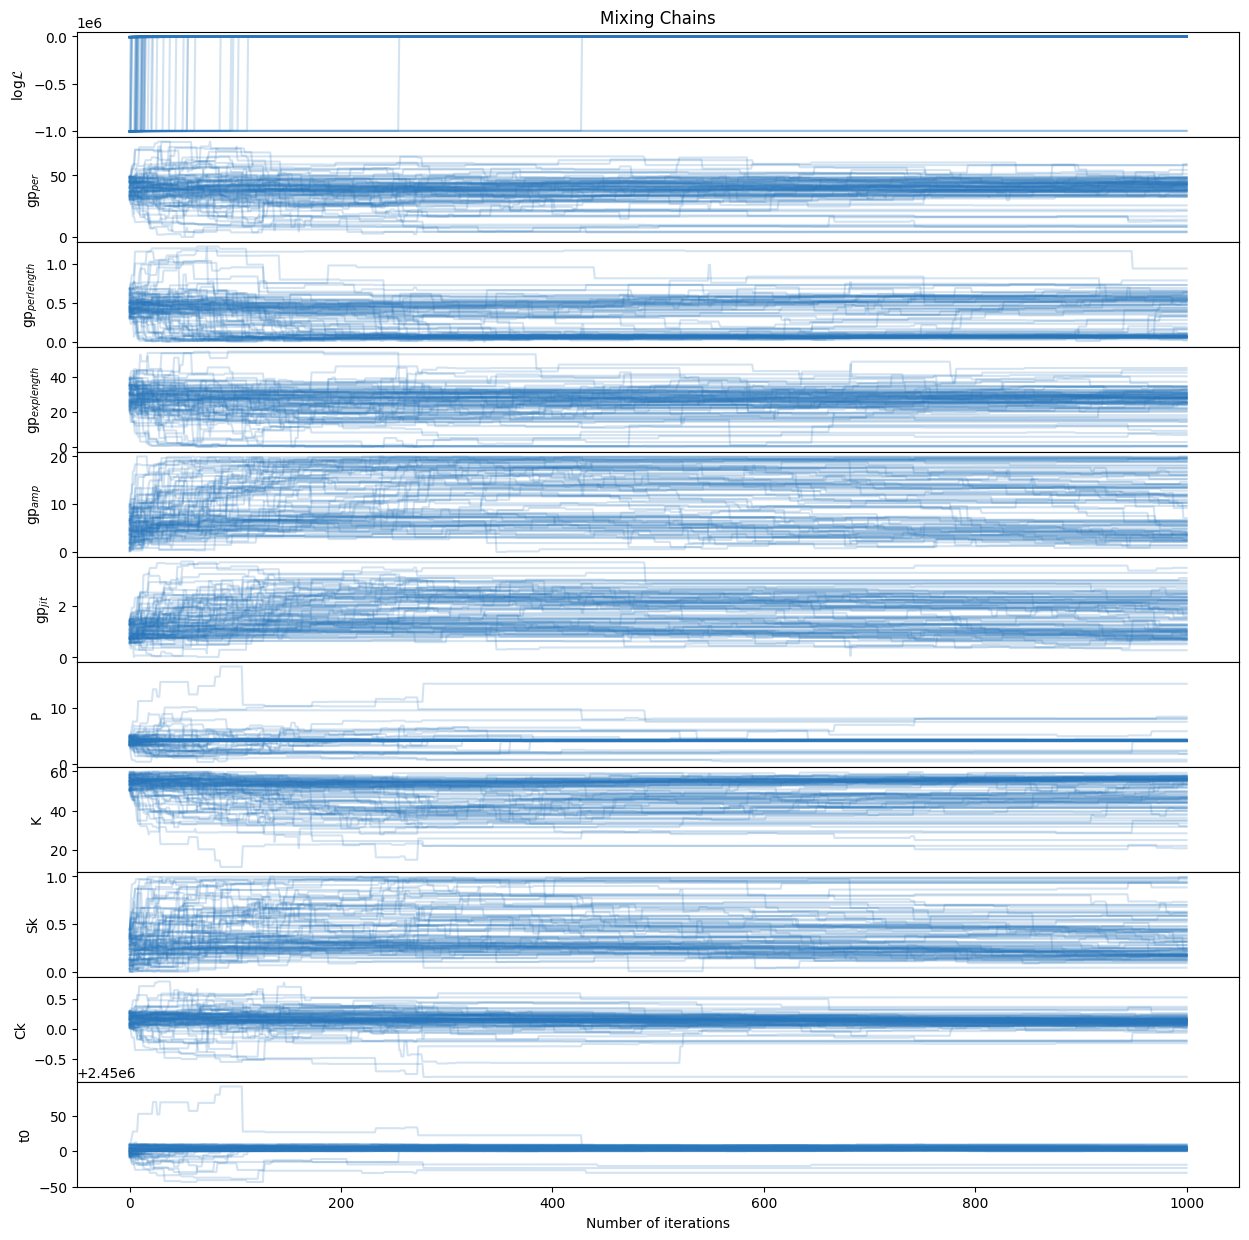

In [10]:
# show the mixing plots
plot.mixing_plot(fin_hparams, "JitterQuasiPer", fin_model_param, model_list, logL_chain)

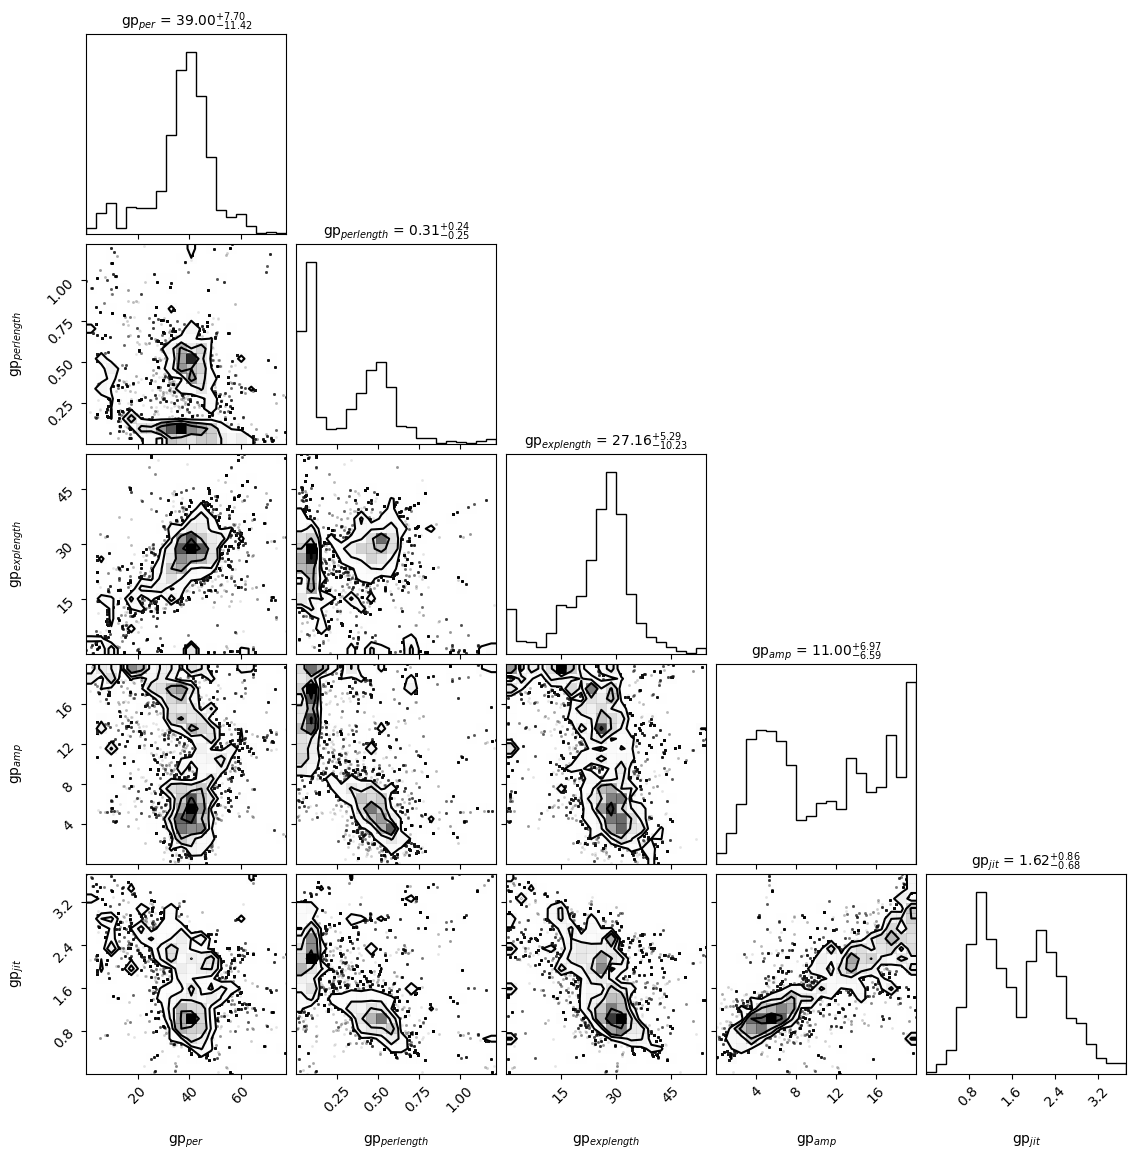

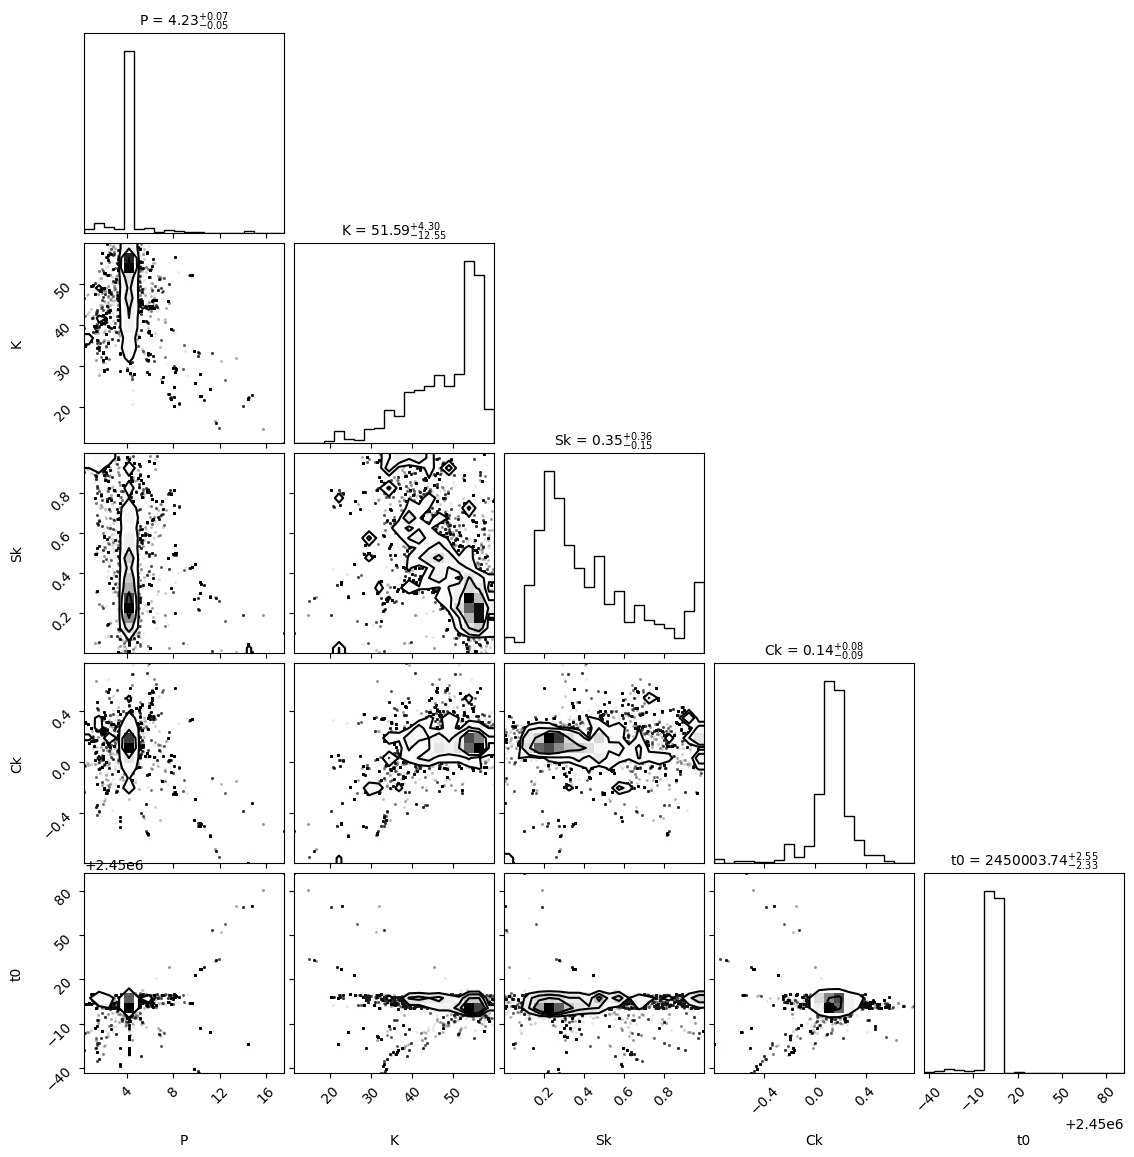

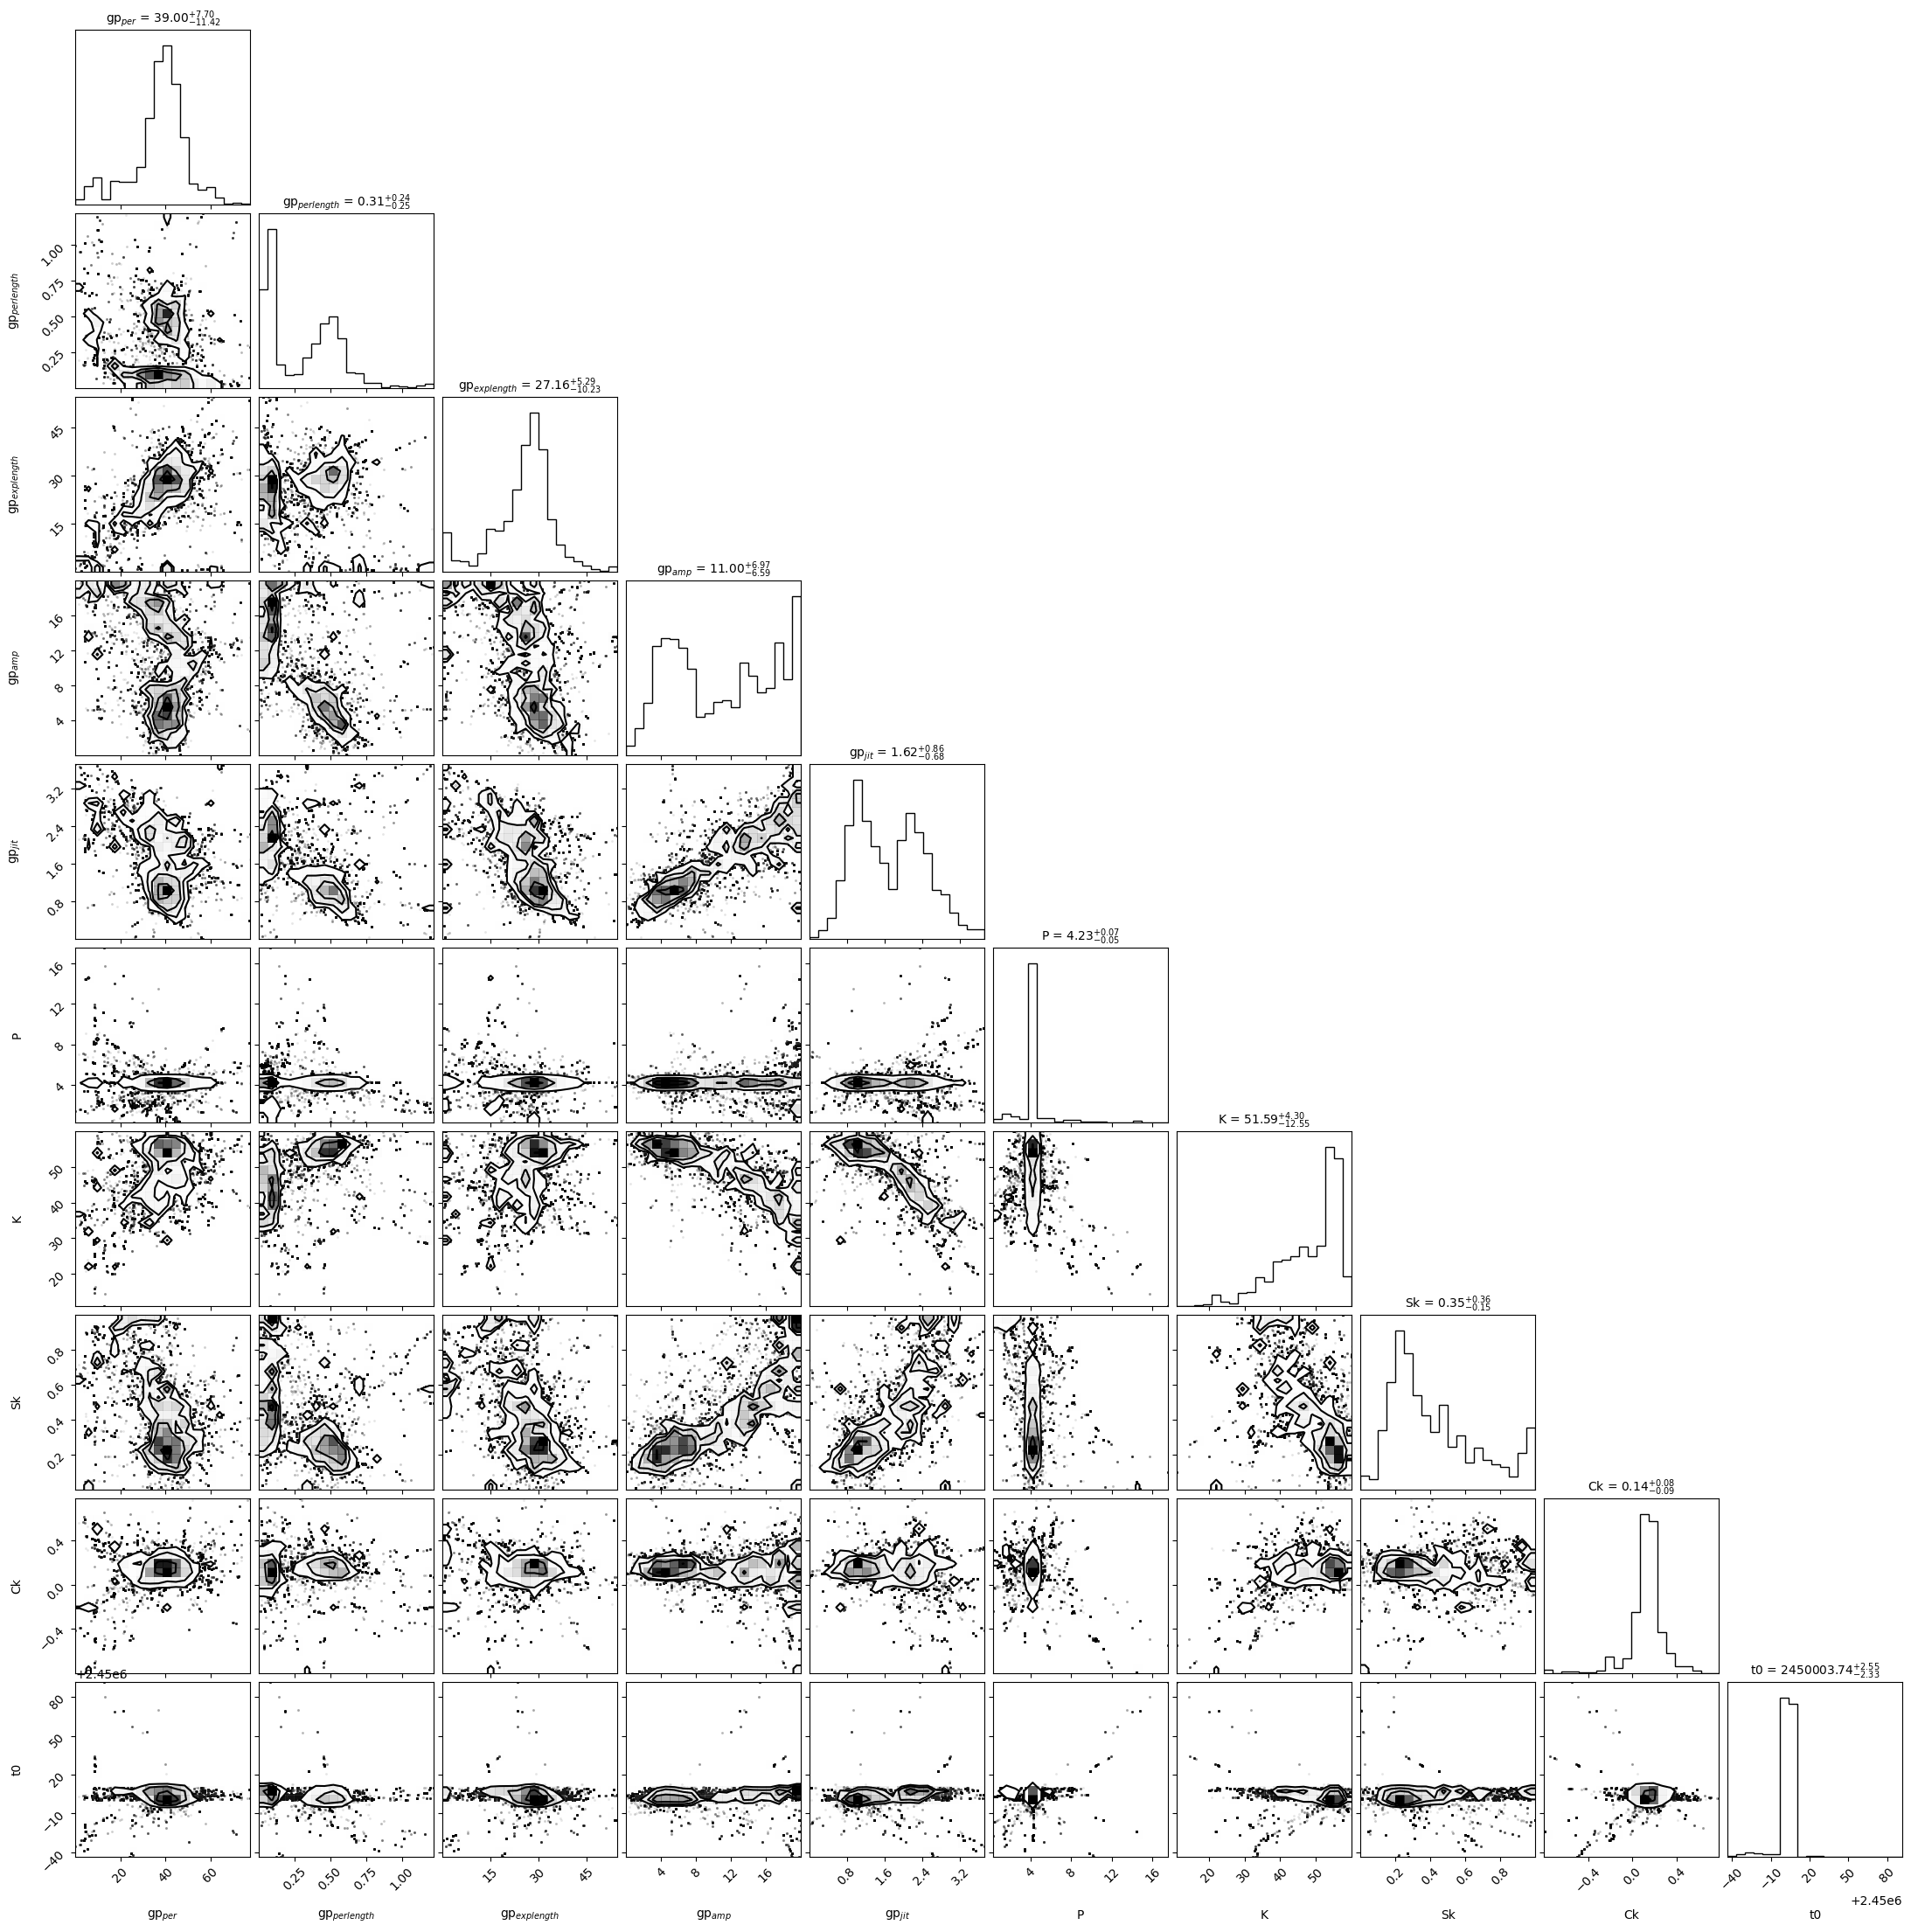

Parameter values after MCMC:  [39.00376479905532, 0.3125732548635094, 27.163880969506017, 11.003014466831859, 1.62105113354358, 4.231365488780199, 51.58522142515935, 0.3455280170449798, 0.14426185136069417, 2450003.743814642]


In [11]:
# there are more corner plots and mixing plots this time as we have more parameters
final_param_values, final_param_erru, final_param_errd = plot.corner_plot(fin_hparams, "JitterQuasiPer", fin_model_param, model_list, errors=True)

In [12]:
# save function run in the same way, more files will be created as there are more parameters, burn in was also increased as we have 1000 iterations
save('/file/path/folder-name/', rv, time, rv_err, model_list = model_list, init_param = model_par, kernel = 'JitterQuasiPer', init_hparam = hparam, prior_list = prior_list, fin_hparam_post = fin_hparams, fin_param_post = fin_model_param, logl_chain = logL_chain, fin_param_values = final_param_values, fin_param_erru = final_param_erru, fin_param_errd = final_param_errd, burnin = 200, fin_to_skck = False)

## Plotting the Data
The final parameters have saved to the final_parameter_values file along with their names and can also be viewed by printing fin_param_values where they will appear in the same order as the corner plots. One last thing we can do with these is re-define all of our hyperparameters and model parameters as these new values and then run 3 of the plotting functions to view the fitted data. The gp_plot function was already mentioned in tutorial 2, we will first run that to see how well the final model lines up with the data. We will then run the keplerian_only_plot function and the phase_plot function which will show us the data and model with the GP and any other model aside from the chosen Keplerian subtracted from it. The phase_plot phase folds the data for the chosen Keplerian, in this case there is only 1 Keplerian to choose from.

Similary to tutorial 2, these plots could have been made before the MCMC with the initial values to see how the initial guesses fitted to the data.

final_param_values contains Sk and Ck rather than ecc and omega, these will have to be converted with the aux.to_ecc function in order to read as ecc and omega or alternatively read from the final_parameter_values file provided fin_to_skck was False in the saving function.

In [13]:
# viewing the final parameter values
print(final_param_values)
# print ecc and omega by entering Sk and Ck into the to_ecc function
ecc, omega = aux.to_ecc(final_param_values[7], final_param_values[8])
print('ecc =', ecc)
print('omega =', omega)

[39.00376479905532, 0.3125732548635094, 27.163880969506017, 11.003014466831859, 1.62105113354358, 4.231365488780199, 51.58522142515935, 0.3455280170449798, 0.14426185136069417, 2450003.743814642]
ecc = 0.14020109232105088
omega = 1.175285735940762


In [14]:
# re-define the hyperparameters and parameters as the final values from the mcmc
hparam['gp_per'] = par.parameter(value = final_param_values[0])
hparam['gp_perlength'] = par.parameter(value = final_param_values[1])
hparam['gp_explength'] = par.parameter(value = final_param_values[2])
hparam['gp_amp'] = par.parameter(value = final_param_values[3])
hparam['gp_jit'] = par.parameter(value = final_param_values[4])
model_par['P'] = par.parameter(value = final_param_values[5])
model_par['K'] = par.parameter(value = final_param_values[6])
model_par['ecc'] = par.parameter(value = ecc)
model_par['omega'] = par.parameter(value = omega)
model_par['t0'] = par.parameter(value = final_param_values[9])

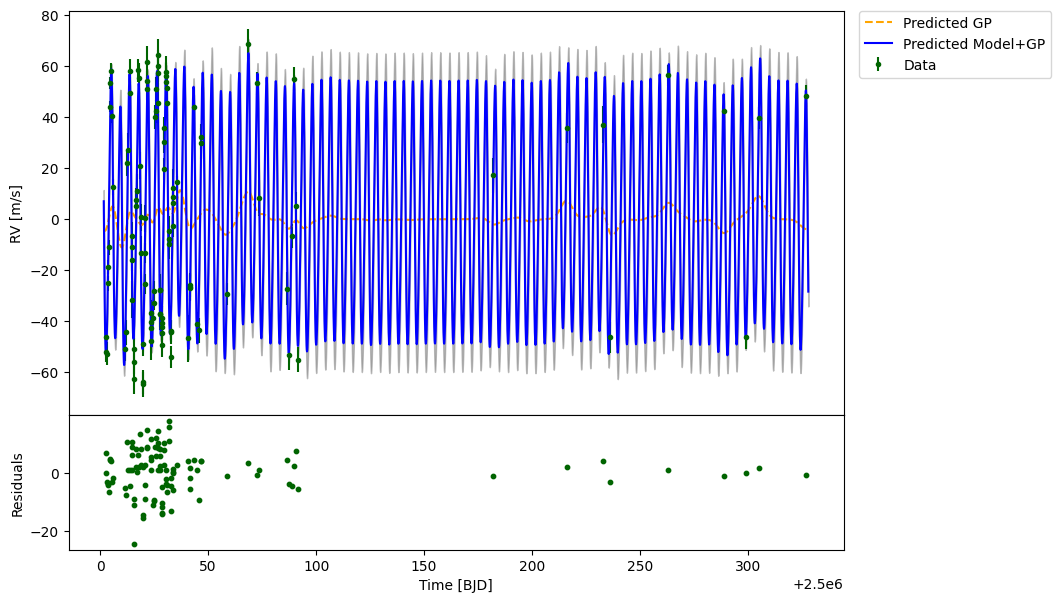

In [15]:
# GP_plot shows the data with the GP and the model plotted over it
plot.GP_plot(time, rv, hparam, 'JitterQuasiPer', rv_err, model_list, model_par, residuals = True)

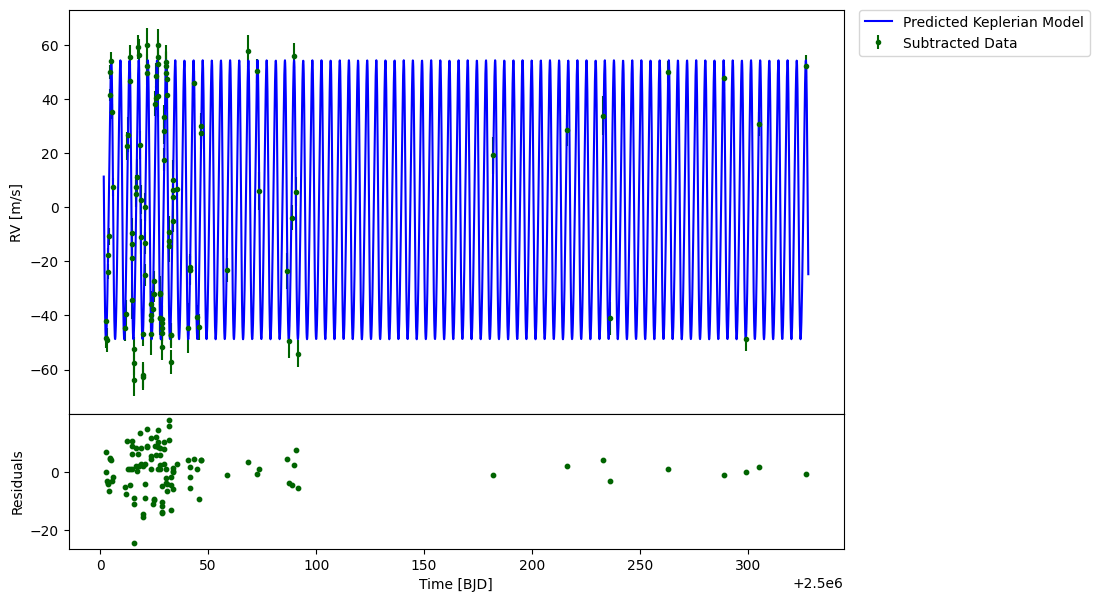

In [16]:
# keplerian_only_plot subtracts any other model and GP from the data that isn't the chosen keplerian
plot.keplerian_only_plot(time, rv, hparam, 'JitterQuasiPer', model_list, model_par, rv_err, residuals = True)

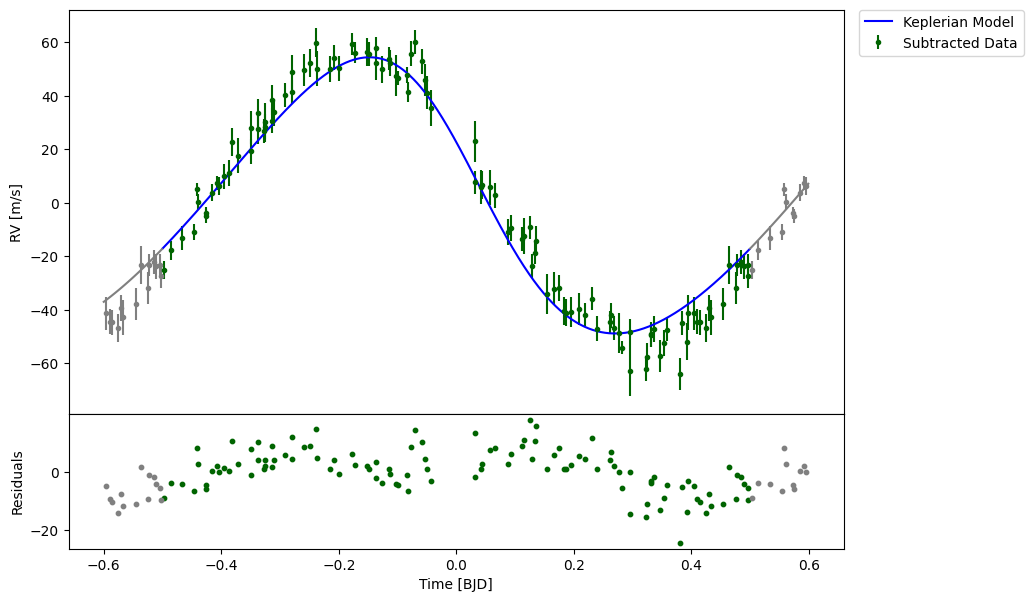

In [17]:
# phase_plot does the same as keplerian_only but phase folds all the data
plot.phase_plot(time, rv, hparam, 'JitterQuasiPer', model_list, model_par, rv_err, residuals = True)